In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

plt.style.use("seaborn")

In [2]:
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

tfk = tf.keras
tfkl = tf.keras.layers

In [3]:
class VariationalBayesModel(tf.Module):
    def __init__(self, optimizer=tf.optimizers.Adam()):
        self.optimizer = optimizer
        
        self.w_prior = tfd.Normal(loc=tf.zeros([]), scale=10*tf.ones([]))
        self.b_prior = tfd.Normal(tf.zeros([]), scale=10*tf.ones([]))
        self.sigma_prior = tfd.LogNormal(loc=tf.zeros([]), scale=tf.ones([]))
        
        self.qw_loc = tf.Variable(tf.zeros([]), name="qw_loc")
        self.qw_scale = tf.Variable(tf.ones([]), name="qw_scale")
        self.qb_loc = tf.Variable(tf.zeros([]), name="qb_loc")
        self.qb_scale = tf.Variable(tf.ones([]), name="qb_scale")
        self.qsigma_loc = tf.Variable(tf.ones([]), name="qsigma_loc")
        self.qsigma_scale = tf.Variable(tf.ones([]), name="qsigma_scale")
        
        self.Root = tfd.JointDistributionCoroutine.Root
        
    def joint_distribution(self, x):
        
        def __joint_distribution():
            w = yield self.Root(self.w_prior)
            b = yield self.Root(self.b_prior)
            sigma = yield self.Root(self.sigma_prior)
            linear = w * x + b
            y = yield tfd.Independent(
                tfd.Normal(loc=linear, scale=sigma),
                reinterpreted_batch_ndims=1
            )

        return tfd.JointDistributionCoroutine(__joint_distribution)
    
    def variational_distribution(self):
        
        def __variational_distribution():
            w = yield self.Root(
                tfd.Normal(loc=self.qw_loc, scale=tf.nn.softplus(self.qw_scale))
            )
            b = yield self.Root(
                tfd.Normal(loc=self.qb_loc, scale=tf.nn.softplus(self.qb_scale))
            )
            sigma = yield self.Root(
                tfd.LogNormal(loc=self.qsigma_loc, scale=tf.nn.softplus(self.qsigma_scale))
            )
            
        return tfd.JointDistributionCoroutine(__variational_distribution)
    
    def log_joint_probability(self, x, w, b, sigma, y):
        joint_prob = self.joint_distribution(x).log_prob([w, b, sigma, y])
        return tf.reduce_mean(joint_prob)
    
    def loss(self, x, y):
        qw_sample, qb_sample, qsigma_sample = self.variational_distribution().sample()
        kl_div = self.w_prior.log_prob(qw_sample) \
               + self.b_prior.log_prob(qb_sample) \
               + self.sigma_prior.log_prob(qsigma_sample)
        log_joint_prob = self.log_joint_probability(x, qw_sample, qb_sample, qsigma_sample, y)
        return kl_div - log_joint_prob
    
    def train(self, x, y, print_loss=False):
        with tf.GradientTape() as g:
            loss_value = self.loss(x, y)
        grads = g.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        if print_loss:
            print("loss: ", loss_value.numpy())
    
    def predict(self, x):
        qw_sample, qb_sample, qsigma_sample = self.variational_distribution().sample()
        joint_dist = self.joint_distribution(x)
        predictive_distribution, samples = joint_dist.sample_distributions(value=[qw_sample, qb_sample, qsigma_sample, None])
        return predictive_distribution, samples
    
    

In [4]:
model = VariationalBayesModel(tf.optimizers.SGD(1e-1))

In [5]:
model.joint_distribution(tf.random.normal(shape=[100, ])).sample()

(<tf.Tensor: id=88, shape=(), dtype=float32, numpy=5.6546383>,
 <tf.Tensor: id=109, shape=(), dtype=float32, numpy=0.31189847>,
 <tf.Tensor: id=143, shape=(), dtype=float32, numpy=1.4220959>,
 <tf.Tensor: id=177, shape=(100,), dtype=float32, numpy=
 array([ 12.47839   ,   0.92276275,   8.197302  ,  10.600454  ,
         14.059065  ,  -0.8661589 ,   6.221601  ,   2.8532162 ,
          7.661247  ,  -9.2614355 ,  -5.997919  ,   5.561102  ,
          1.7208993 ,  -0.25545967, -10.96863   ,   6.78297   ,
          6.030717  ,   5.302308  ,   1.4680169 ,   7.313816  ,
         -2.113021  ,   9.3659935 ,   2.0271804 ,  13.280983  ,
         -1.9574577 ,  -7.3985224 ,   2.114698  ,  -9.681598  ,
         -9.937612  ,  -0.8526027 ,  -2.497451  ,   5.404141  ,
         -0.18469143,  -0.7792499 ,   0.5466834 ,  -0.1858337 ,
          8.828292  ,  -7.8696637 ,  -1.477525  ,   0.6025442 ,
          6.010813  ,  -0.13703942, -11.360168  ,  -4.464151  ,
          4.7191715 ,   8.423402  ,  -1.1547685

In [6]:
model.variational_distribution().sample()

(<tf.Tensor: id=201, shape=(), dtype=float32, numpy=-0.53409106>,
 <tf.Tensor: id=225, shape=(), dtype=float32, numpy=-0.5607694>,
 <tf.Tensor: id=271, shape=(), dtype=float32, numpy=2.0530598>)

In [7]:
def toy_data():
    x = np.random.rand(100).reshape(100, 1)
    y = 3*x + 2 + 0.1*np.random.randn(100).reshape(100, 1)
    return tf.convert_to_tensor(x, dtype=tf.float32), tf.convert_to_tensor(y, dtype=tf.float32)

In [8]:
train_x, train_y = toy_data()

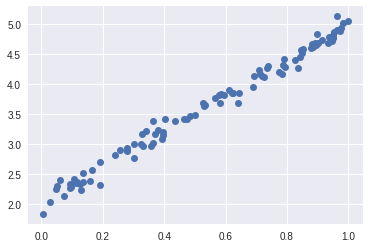

In [9]:
plt.plot(train_x, train_y, "o")

In [11]:
for i in range(1000):
    print_flag = True if (i+1)%100 == 0 else False
    model.train(train_x, train_y, print_flag)

loss:  1.9683905
loss:  -0.26891947
loss:  0.86920214
loss:  1.5348177
loss:  0.4581418
loss:  -0.22240496
loss:  0.8441076
loss:  -0.2844329
loss:  0.3220744
loss:  0.30397558


In [12]:
x_test = tf.linspace(-0.5, 1.5, 1000)
dist, _ = model.predict(x_test)

In [13]:
predictive_dist = dist[-1]

In [14]:
sample = predictive_dist.sample()

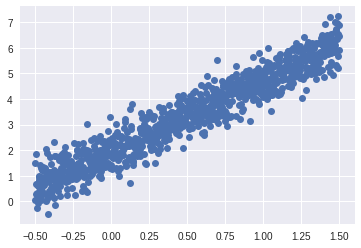

In [15]:
plt.plot(x_test.numpy(), sample.numpy(), "o")

In [16]:
many_samples = predictive_dist.sample(10000)
mean = tf.reduce_mean(many_samples, axis=0)
std = tf.sqrt(tf.reduce_mean((many_samples - mean)**2, axis=0))

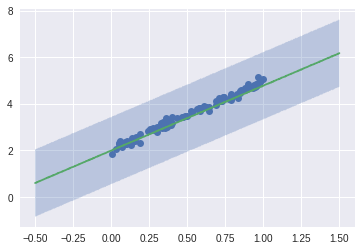

In [17]:
plt.plot(train_x, train_y, "o")
plt.plot(x_test.numpy(), mean.numpy())
plt.fill_between(x_test.numpy(), mean+3*std, mean-3*std, alpha=0.3)